# 학습된 모형 시각화

- 중간 층의 activation 시각화
- 필터 시각화
- 클래스 활성화에 대한 히트맵을 이미지에 시각화


In [1]:
import keras
from keras import models, layers
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import numpy as np

Using TensorFlow backend.


In [2]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10,activation='softmax'))

In [3]:
(images,labels),(test_images, test_labels) = fashion_mnist.load_data()
images = images.reshape((-1,28,28,1))
images = images.astype('float32')/255
train_images = images[:50000]
val_images = images[50000:]

test_images = test_images.reshape((-1, 28, 28, 1))
test_images = test_images.astype('float32') / 255

labels = to_categorical(labels)
train_labels = labels[:50000]
val_labels = labels[50000:]
test_labels = to_categorical(test_labels)

4423680/4422102 [==============================] - 2s 0us/step


In [4]:
model.compile(optimizer='rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size = 64, validation_data=(val_images, val_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 32s 640us/step - loss: 0.5654 - accuracy: 0.7904 - val_loss: 0.4786 - val_accuracy: 0.8292
Epoch 2/5
50000/50000 [==============================] - 32s 633us/step - loss: 0.3472 - accuracy: 0.8724 - val_loss: 0.3630 - val_accuracy: 0.8619
Epoch 3/5
50000/50000 [==============================] - 32s 635us/step - loss: 0.2926 - accuracy: 0.8935 - val_loss: 0.3021 - val_accuracy: 0.8847
Epoch 4/5
50000/50000 [==============================] - 31s 626us/step - loss: 0.2591 - accuracy: 0.9057 - val_loss: 0.2840 - val_accuracy: 0.8954
Epoch 5/5
50000/50000 [==============================] - 32s 631us/step - loss: 0.2351 - accuracy: 0.9123 - val_loss: 0.2672 - val_accuracy: 0.9006


In [5]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 2s 196us/step


In [6]:
test_acc

0.8967000246047974

## Save and Load model


In [9]:
model.save('fashion_mnist_cnn.h5')

In [13]:
model = models.load_model('fashion_mnist_cnn.h5')

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

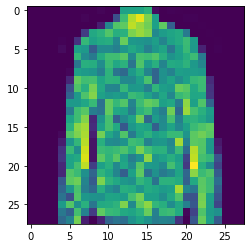

In [15]:
test_image = test_images[101:102]

plt.imshow(test_image.reshape((28,28)))
plt.show()

# Visualize activation

In [16]:
layer_outputs = [layer.output for layer in model.layers[:5]]

In [17]:
activation_model = models.Model(inputs=model.input,outputs = layer_outputs)

In [18]:
activations = activation_model.predict(test_image)

In [19]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 26, 26, 32)


<Figure size 432x288 with 0 Axes>

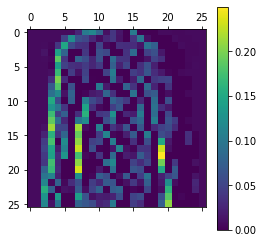

In [20]:
plt.figure()
plt.matshow(first_layer_activation[0,:,:,10])
plt.colorbar()
plt.show()

## print all activation 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


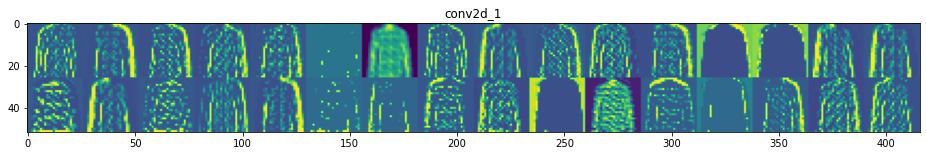

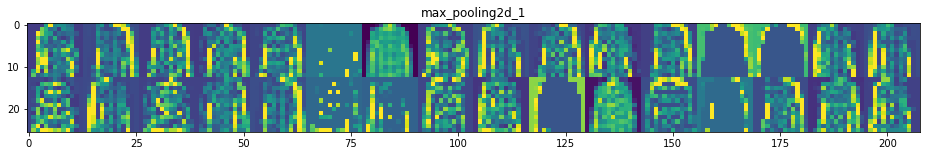

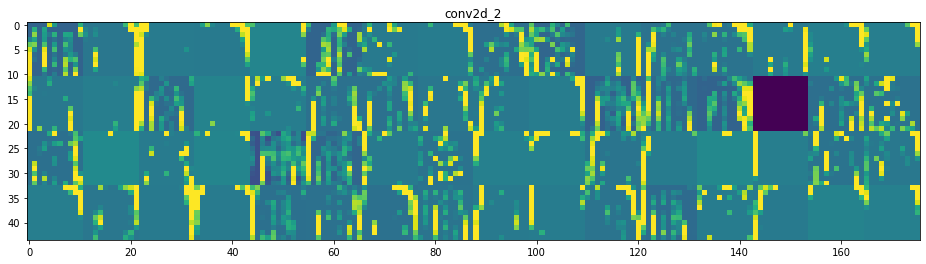

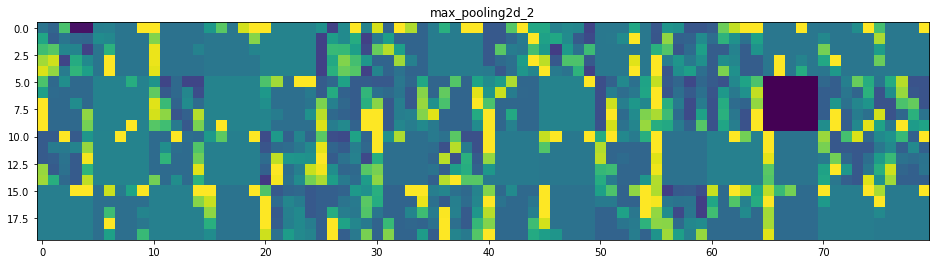

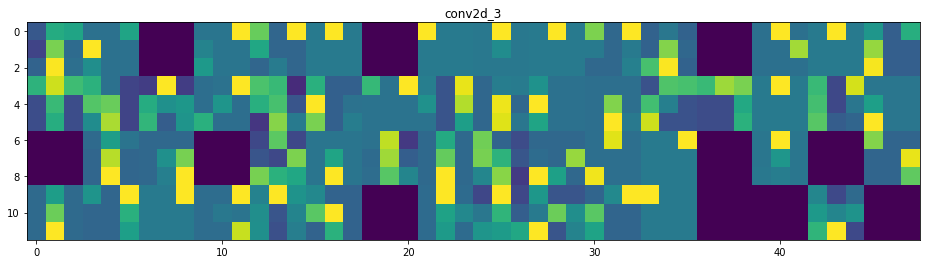

In [21]:
layer_names = []
for layer in model.layers[:5]:
    layer_names.append(layer.name)

images_per_row = 16

# 특성 맵을 그립니다
for layer_name, layer_activation in zip(layer_names, activations):
    # 특성 맵에 있는 특성의 수
    n_features = layer_activation.shape[-1]

    # 특성 맵의 크기는 (1, size, size, n_features)입니다
    size = layer_activation.shape[1]

    # 활성화 채널을 위한 그리드 크기를 구합니다
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 각 활성화를 하나의 큰 그리드에 채웁니다
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 그래프로 나타내기 좋게 특성을 처리합니다
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 그리드를 출력합니다
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto')

plt.show()


아래 층으로 내려갈 수록 image classificaiton 을 위한 정보가 점점 증가함

## other test images

다른 test images에 대해서 같은 것을 적용해 보아서 다른 이미지의 경우에 어떻게 활성화 되는 것이 달라지는지 확인하기

# Visualize Filter

선택된 필터가 최대로 응답하는 이미지를 찾음

- 간단한 MNIST 예제보다 Imagenet 데이터로 이미 학습된 모델인 VGG16 을 사용
- 충분한 데이터가 있어야지만 유용한 특성들을 학습하게 되기 때문

![대체 텍스트](https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network.jpg)

In [25]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])


58892288/58889256 [==============================] - 5s 0us/step


In [26]:
layer_output.shape

TensorShape([None, None, None, 256])

- VGG 모델의 output 은 (150,150,3)에 해당
- 위의 loss function은 특정 filter로 부터 계산되는 output (여기에서는 'block3_conv1')의 평균 값으로 정함
- 이를 최대화 하는 input이라는 것은 해당 filter 의 output을 제일 잘 활성화시키는 input을 구하겠다는 것임

In [27]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [28]:
# gradients 함수가 반환하는 텐서 리스트(여기에서는 크기가 1인 리스트)에서 첫 번째 텐서를 추출합니다
grads = K.gradients(loss, model.input)[0]

In [29]:
# 0 나눗셈을 방지하기 위해 1e–5을 더합니다 (Normalization!)
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

위의 gradient 정보를 이용하여 위의 output loss를 최대화 하는 이미지를 구할 것임

In [30]:
iterate = K.function([model.input], [loss, grads])


## Input data size
- 활용이 용이하도록 input data size를 변경 가능한 모델로 줌
- 원래 imagenet data size인 (255,255,3)을 주어도 되지만 (150,150,3) 을 주어도 계산이 가능함
- 이것은 우리가 convolutional layer를 사용하기 때문임. 
- 같은 convolutional filter 크기를 사용하므로 상관이 없음
- pretrained 되었다는 것은 filter가 학습되었다는 것!
- input이 다른 것은 사실 Dense Layer에서는 문제가될 수 있음


In [31]:
loss_value, grads_value = iterate([np.zeros((1, 255, 255, 3))])

In [32]:
input_img_data = np.random.random((1, 255, 255, 3)) * 20 + 128.

# 업데이트할 그래디언트의 크기
step = 1.
for i in range(40):   # 경사 상승법을 40회 실행합니다
    # 손실과 그래디언트를 계산합니다
    loss_value, grads_value = iterate([input_img_data])
    # 손실을 최대화하는 방향으로 입력 이미지를 수정합니다
    input_img_data += grads_value * step

## Define Functions
- output image 정규화
- layer name과  몇번째 filter 인지 정해주면 output으로 그 filter의 output을 최대화 해주는 input image를 계산해 주는 함수를 작성

In [33]:
def deprocess_image(x):
    # 텐서의 평균이 0, 표준 편차가 0.1이 되도록 정규화합니다
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # [0, 1]로 클리핑합니다
    x += 0.5
    x = np.clip(x, 0, 1)

    # RGB 배열로 변환합니다 (0~255) 의 값이 되도록 변환
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

아래 함수에서도 size로 input 이미지의 크기를 정해줄 수 있음
intput 크기가 클 수록 미분해서 얻어야 하는 값들이 많아 지므로 현재는 (150,150,3)을 사용

In [34]:
def generate_pattern(layer_name, filter_index, size=150):
    # 주어진 층과 필터의 활성화를 최대화하기 위한 손실 함수를 정의합니다
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # 손실에 대한 입력 이미지의 그래디언트를 계산합니다
    grads = K.gradients(loss, model.input)[0]

    # 그래디언트 정규화
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # 입력 이미지에 대한 손실과 그래디언트를 반환합니다
    iterate = K.function([model.input], [loss, grads])
    
    # 잡음이 섞인 회색 이미지로 시작합니다
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 경사 상승법을 40 단계 실행합니다
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

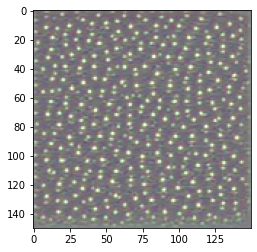

In [35]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()


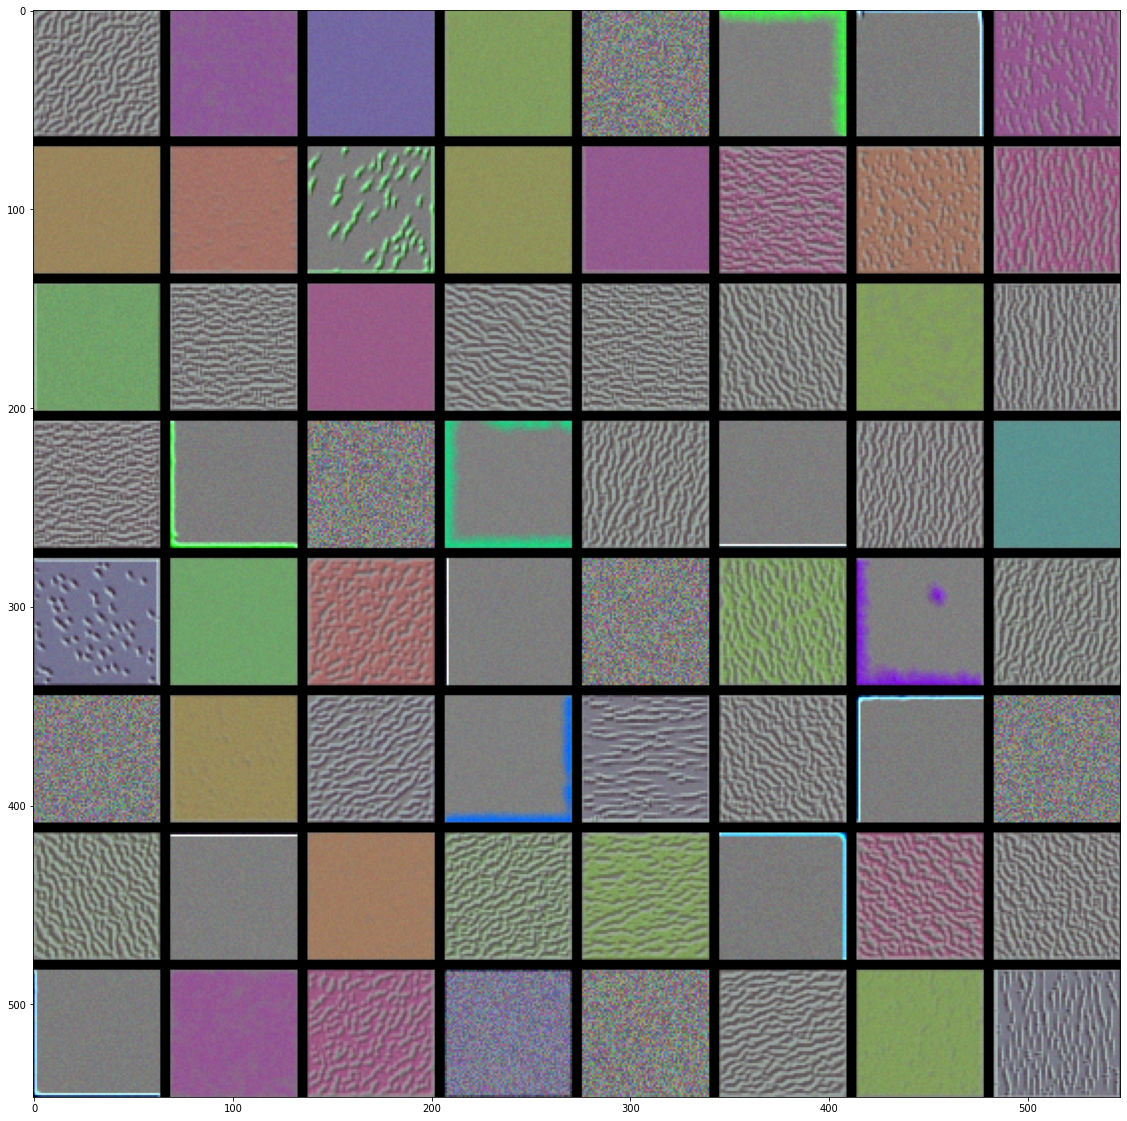

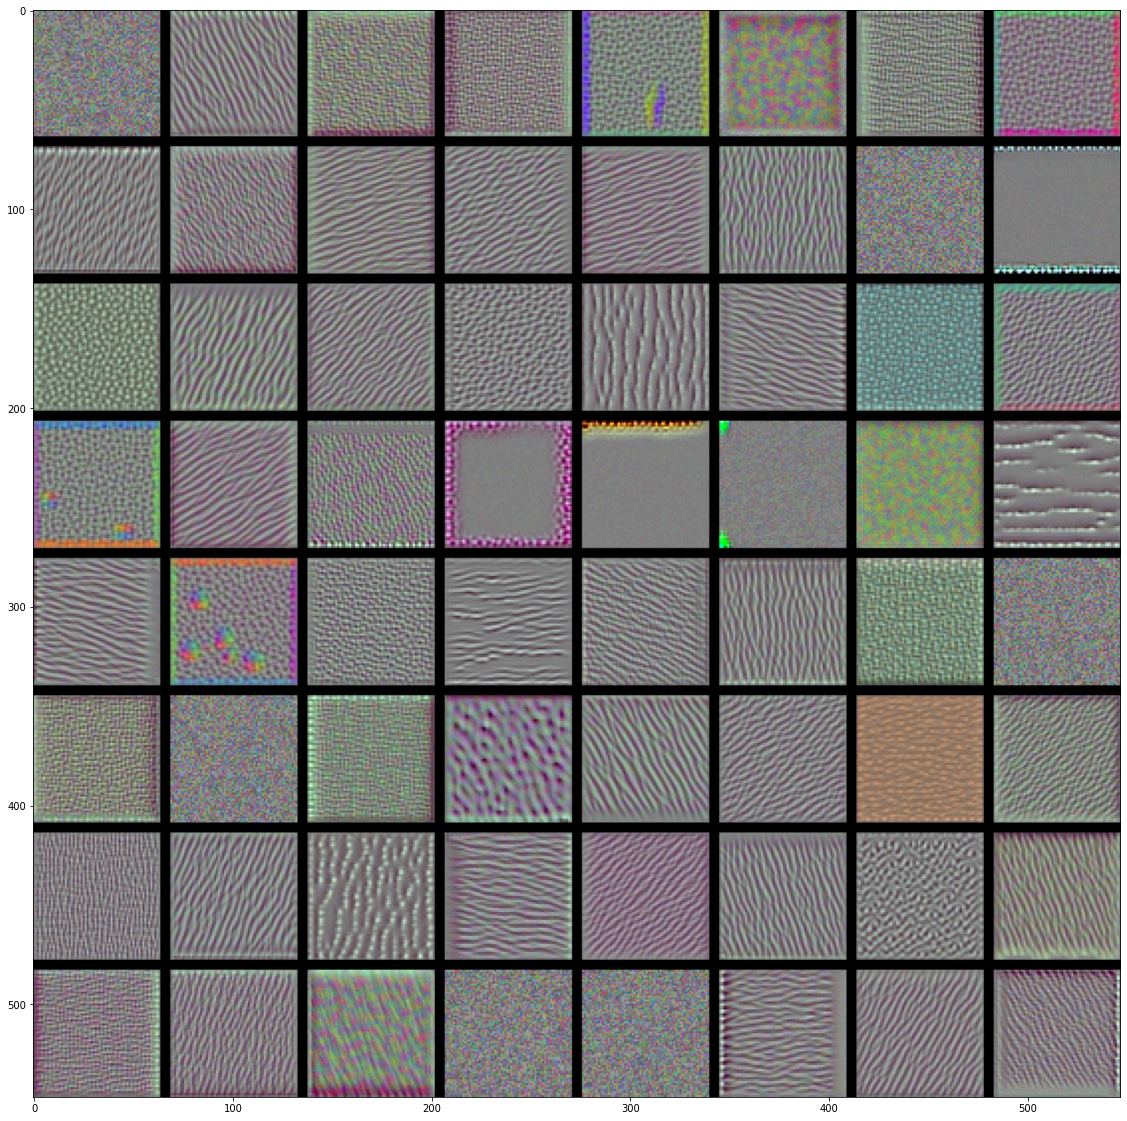

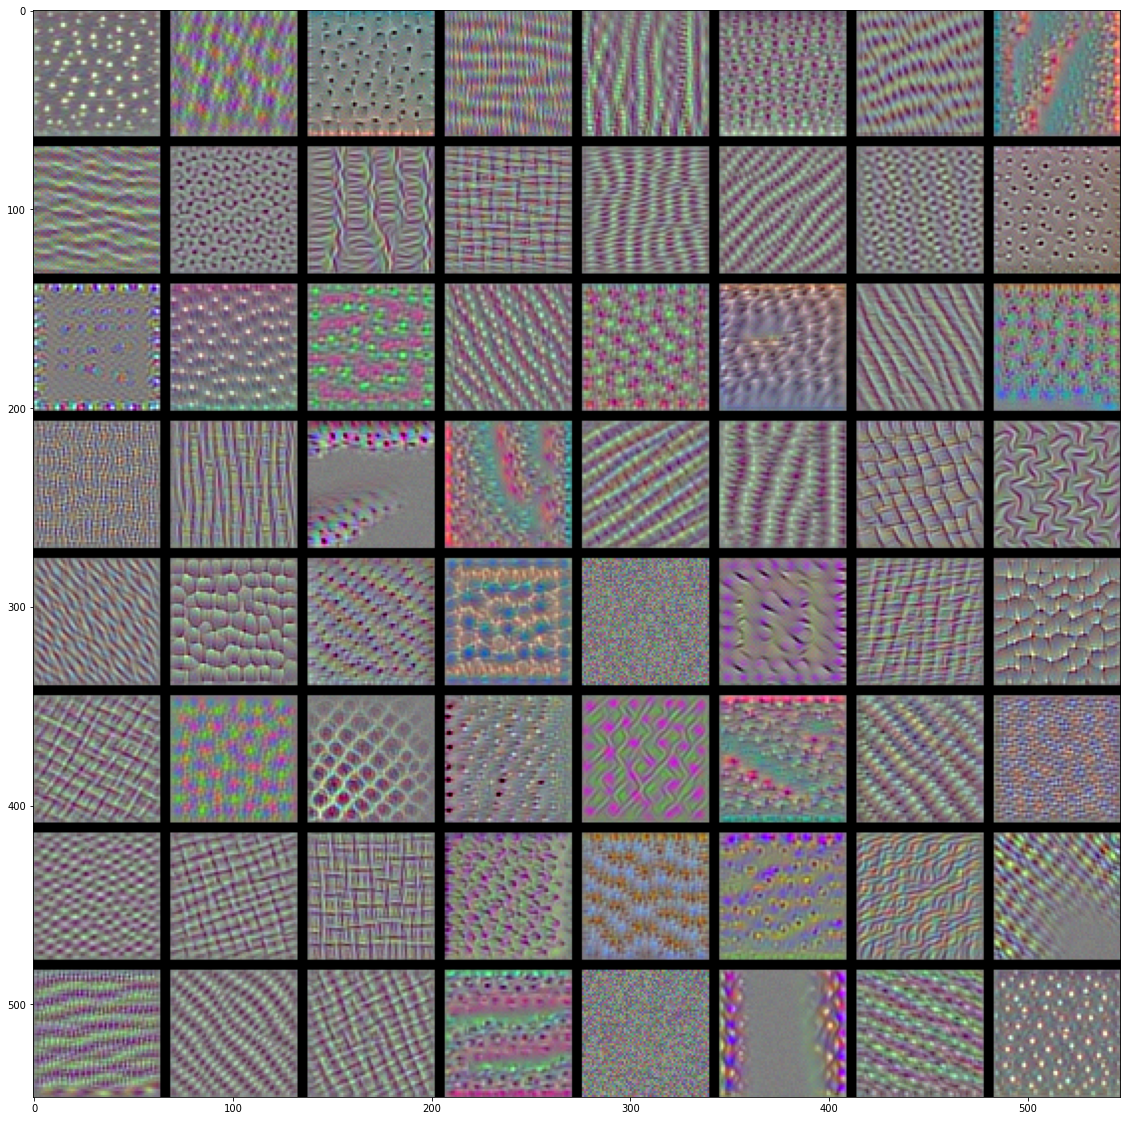

In [ ]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']:
    size = 64
    margin = 5

    # 결과를 담을 빈 (검은) 이미지
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')

    for i in range(8):  # results 그리드의 행을 반복합니다
        for j in range(8):  # results 그리드의 열을 반복합니다
            # layer_name에 있는 i + (j * 8)번째 필터에 대한 패턴 생성합니다
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # results 그리드의 (i, j) 번째 위치에 저장합니다
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # results 그리드를 그립니다
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()


# Visualize the impact to output class

앞부분까지는 filter를 보기 위함이었으므로 convolutional layers 까지만 봤지만 classification 을 위해서는 dense layer 까지 포함시킨 완전한 모델이 필요함


In [ ]:
import keras
from keras import models, layers
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import numpy as np
from keras.models import load_model
from keras.applications import VGG16
from keras import backend as K

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
K.clear_session()

model = VGG16(weights = 'imagenet')
model.summary()



553467904/553467096 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [ ]:
import os,sys
os.getcwd()

'/content'

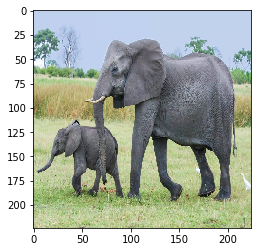

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# 이미지 경로
img_path = './sample_image.jpg'

# 224 × 224 크기의 파이썬 이미징 라이브러리(PIL) 객체로 반환됩니다
img = image.load_img(img_path, target_size=(224, 224))

# (224, 224, 3) 크기의 넘파이 float32 배열
x = image.img_to_array(img)

# 차원을 추가하여 (1, 224, 224, 3) 크기의 배치로 배열을 변환합니다
x = np.expand_dims(x, axis=0)
plt.figure()
plt.imshow(x[0]/255)
plt.show()
# 데이터를 전처리합니다(채널별 컬러 정규화를 수행합니다)
x = preprocess_input(x)

In [ ]:
x.shape

(1, 224, 224, 3)

In [ ]:
preds = model.predict(x)

In [ ]:
preds.shape

(1, 1000)

In [ ]:
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 0.853815), ('n01871265', 'tusker', 0.12676603), ('n02504013', 'Indian_elephant', 0.019279903)]


## (코끼리)임을 영향을 주는 input 부분

In [ ]:
most_class = np.argmax(preds[0])
print(most_class)

386


In [ ]:

# 예측 벡터의 '코끼리' 항목
african_crocodile_output = model.output[:, most_class]

# VGG16의 마지막 합성곱 층인 block5_conv3 층의 특성 맵
last_conv_layer = model.get_layer('block5_conv3')

# block5_conv3의 특성 맵 출력에 대한 '코끼리' 클래스의 그래디언트
grads = K.gradients(african_crocodile_output, last_conv_layer.output)[0]

print(grads.shape)

# 특성 맵 채널별 그래디언트 평균 값이 담긴 (512,) 크기의 벡터
## 채널이 총 512 개 그 마지막 conv layer의 output 크기는 (14,14)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)

# 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구합니다
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 악어가 있는 샘플 이미지를 주입하고 두 개의 넘파이 배열을 얻습니다
pooled_grads_value, conv_layer_output_value = iterate([x])

# "코끼리" 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱합니다
## grads 가 클 수록 그 채널의 변화에 따른 output의 변화가 크다는 것을 의미 (그 채널에 더 큰 가중치를 줌)
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵입니다
heatmap = np.mean(conv_layer_output_value, axis=-1)

(?, 14, 14, 512)
(512,)


In [ ]:
heatmap.shape

(14, 14)

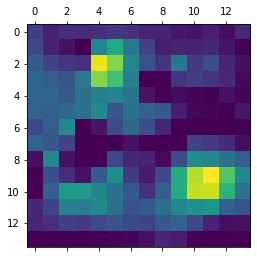

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap, cmap='viridis')
plt.show()

In [ ]:
import cv2

# cv2 모듈을 사용해 원본 이미지를 로드합니다
img = cv2.imread(img_path)

# heatmap을 원본 이미지 크기에 맞게 변경합니다
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap을 RGB 포맷으로 변환합니다
heatmap = np.uint8(255 * heatmap)

# 히트맵으로 변환합니다
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4는 히트맵의 강도입니다
superimposed_img = heatmap * 0.4 + img

In [ ]:
cv2.imwrite('./sample_data/cam.jpg', superimposed_img)

True

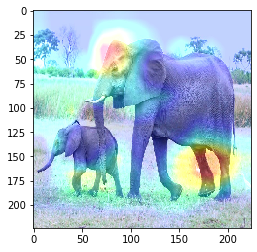

In [ ]:
# 이미지 경로
cam_img_path = './sample_data/cam.jpg'

# 224 × 224 크기의 파이썬 이미징 라이브러리(PIL) 객체로 반환됩니다
superimposed_img = image.load_img(cam_img_path, target_size=(224, 224))

# (224, 224, 3) 크기의 넘파이 float32 배열
superimposed_img1 = image.img_to_array(superimposed_img)

# 차원을 추가하여 (1, 224, 224, 3) 크기의 배치로 배열을 변환합니다
superimposed_img1 = np.expand_dims(superimposed_img1, axis=0)
plt.figure()
plt.imshow(superimposed_img1[0]/255)
plt.show()

